In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
import wget
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv'
#filename = wget.download(url)

In [3]:
url = 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv'
#filename = wget.download(url)

In [4]:
import wget
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv'
#filename = wget.download(url)

In [5]:
images_boxable_file = 'train-images-boxable-with-rotation.csv'
annotations_bbox_file = 'train-annotations-bbox.csv'
class_descriptions_file = 'class-descriptions-boxable.csv'

In [6]:
images_boxable = pd.read_csv(images_boxable_file)
images_boxable.head()

ImageID Subset                                        OriginalURL  \
0  4fa8054781a4c382  train  https://farm3.staticflickr.com/5310/5898076654...   
1  b37f763ae67d0888  train  https://c1.staticflickr.com/1/67/197493648_628...   
2  7e8584b0f487cb9e  train  https://c7.staticflickr.com/8/7056/7143870979_...   
3  86638230febe21c4  train  https://farm5.staticflickr.com/5128/5301868579...   
4  249086e72671397d  train  https://c6.staticflickr.com/4/3930/15342460029...   

                                  OriginalLandingURL  \
0  https://www.flickr.com/photos/michael-beat/589...   
1  https://www.flickr.com/photos/drstarbuck/19749...   
2  https://www.flickr.com/photos/circasassy/71438...   
3  https://www.flickr.com/photos/ajcreencia/53018...   
4  https://www.flickr.com/photos/codnewsroom/1534...   

                                        License  \
0  https://creativecommons.org/licenses/by/2.0/   
1  https://creativecommons.org/licenses/by/2.0/   
2  https://creativecommons.org/licenses/by/2.0/   
3  https://creativecommons.org/licenses/by/2.0/   
4  https://creativecommons.org/licenses/by/2.0/   

                              AuthorProfileURL        Author  \
0  https://www.flickr.com/people/michael-beat/  Michael Beat   
1    https://www.flickr.com/people/drstarbuck/         Karen   
2    https://www.flickr.com/people/circasassy/    CircaSassy   
3    https://www.flickr.com/people/ajcreencia/          Alex   
4   https://www.flickr.com/people/codnewsroom/  COD Newsroom   

                                               Title  OriginalSize  \
0                                   ...die FNF-Kerze       4405052   
1                               Three boys on a hill        494555   
2  A Christmas carol and The cricket on the heart...       2371584   
3                                    Abbey and Kenny        949267   
4  Suburban Law Enforcement Academy 20th Annivers...       6541758   

                OriginalMD5  \
0  KFukvivpCM5QXl5SqKe41g==   
1  9IzEn38GRNsVpATuv7gzEA==   
2  3hQwu0iSzY1VIoXiwp0/Mg==   
3  onB+rCZnGQg5PRX7xOs18Q==   
4  MjpaAVbMAWbCusSaxI1D7w==   

                                    Thumbnail300KURL  Rotation  
0  https://c1.staticflickr.com/6/5310/5898076654_...       0.0  
1  https://c3.staticflickr.com/1/67/197493648_628...       0.0  
2  https://c7.staticflickr.com/8/7056/7143870979_...       0.0  
3  https://c4.staticflickr.com/6/5128/5301868579_...       NaN  
4  https://c1.staticflickr.com/4/3930/15342460029...       0.0

In [7]:
annotations_bbox = pd.read_csv(annotations_bbox_file)
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

In [8]:
class_descriptions = pd.read_csv(class_descriptions_file, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

In [9]:
# Code for plotting bounding box
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Image: (1627, 1872, 3)
Coordinates: (326, 490), (1453, 1305)


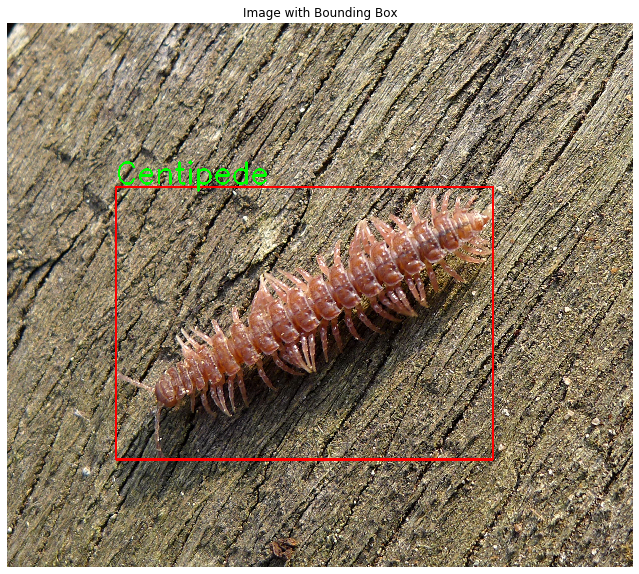

Image: (2000, 3008, 3)
Coordinates: (1504, 1089), (2391, 1407)


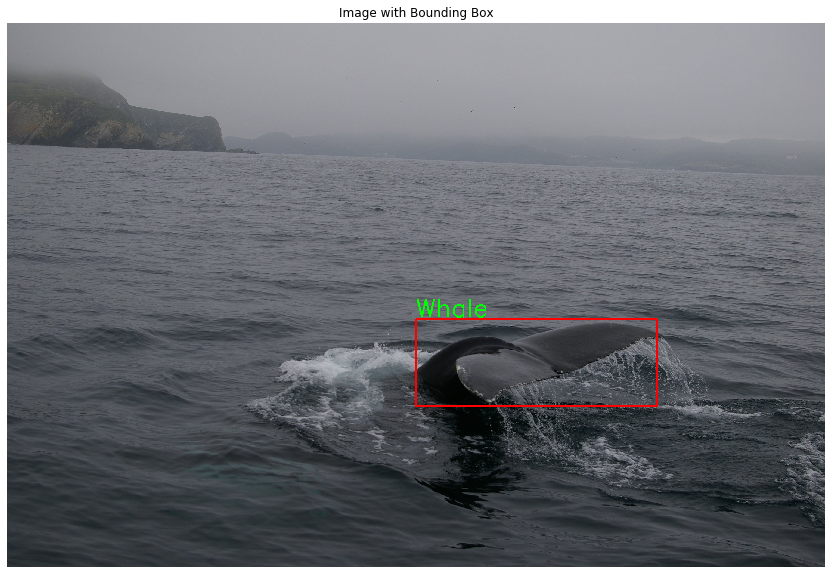

Image: (1856, 2784, 3)
Coordinates: (1, 0), (2782, 1763)


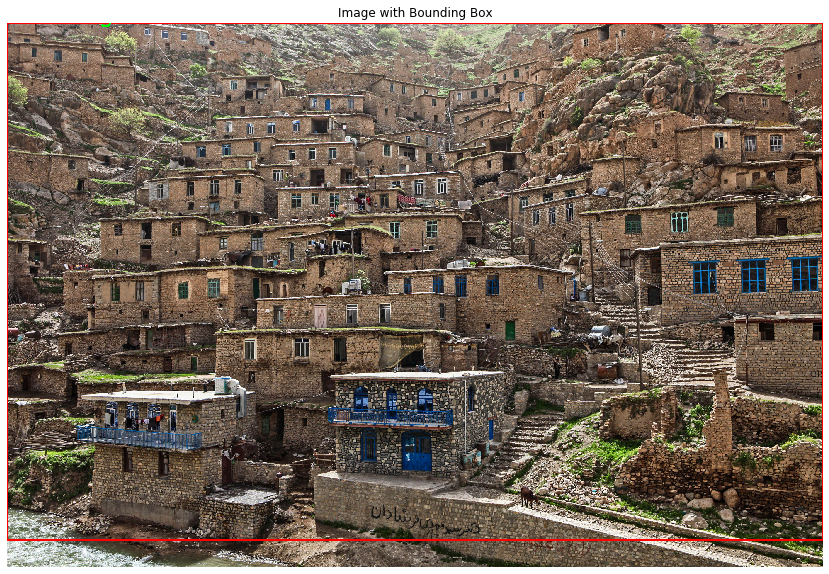

Image: (1200, 1600, 3)
Coordinates: (0, 0), (1599, 1199)


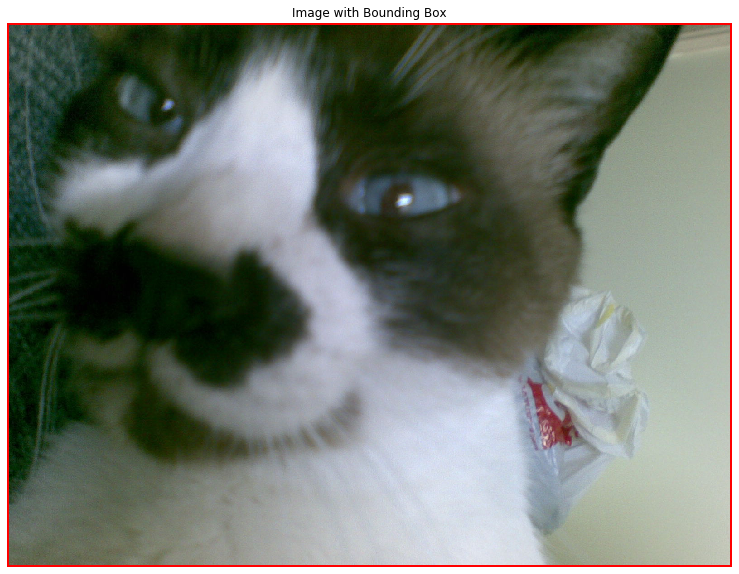

Image: (1594, 1360, 3)
Coordinates: (47, 337), (1301, 1528)


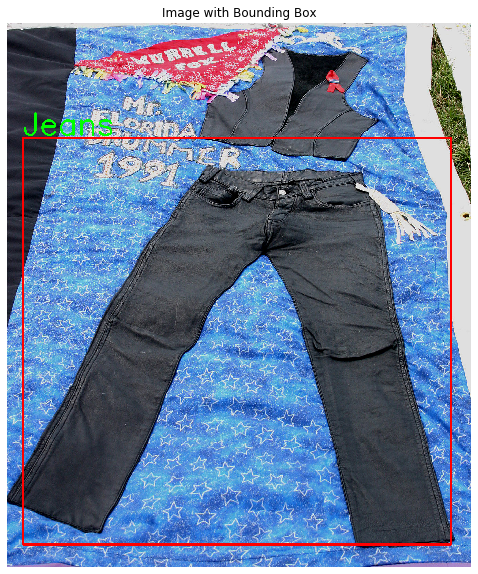

In [10]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

In [11]:
class_descriptions[1].count()

601

In [12]:
# Find the label_name for 'Bed', 'Chair' and 'Table' classes
bed_pd = class_descriptions[class_descriptions[1]=='Bed']
chair_pd = class_descriptions[class_descriptions[1]=='Chair']
table_pd = class_descriptions[class_descriptions[1]=='Table']

In [13]:
bed_pd

0    1
257  /m/03ssj5  Bed

In [14]:
label_name_bed = bed_pd[0].values[0]
label_name_chair = chair_pd[0].values[0]
label_name_table = table_pd[0].values[0]

label_name_bed

'/m/03ssj5'

In [15]:
bed_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_bed]
chair_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_chair]
table_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_table]

bed_bbox

ImageID     Source  LabelName  Confidence      XMin  \
5953      00041cc3701f7805     xclick  /m/03ssj5           1  0.135112   
5954      00041cc3701f7805     xclick  /m/03ssj5           1  0.179862   
9974      00074503ceae5131     xclick  /m/03ssj5           1  0.000000   
13671     000a54f1bdb96839     xclick  /m/03ssj5           1  0.000000   
17469     000da932ca7e68e4     xclick  /m/03ssj5           1  0.000000   
...                    ...        ...        ...         ...       ...   
14585203  ff7f55b7f6794f63     xclick  /m/03ssj5           1  0.000000   
14595452  ffb716498f082103     xclick  /m/03ssj5           1  0.180000   
14600295  ffce182988b6b746     xclick  /m/03ssj5           1  0.000000   
14602507  ffd718211ba34626  activemil  /m/03ssj5           1  0.006250   
14602925  ffd95054b5fa8ba3     xclick  /m/03ssj5           1  0.000000   

              XMax      YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  \
5953      0.366609  0.420573  0.625000           1            0          0   
5954      0.405336  0.436198  0.856771           0            0          0   
9974      0.999375  0.000000  0.999062           1            1          0   
13671     0.999167  0.028125  0.999375           0            1          0   
17469     0.753125  0.328330  0.993433           1            0          0   
...            ...       ...       ...         ...          ...        ...   
14585203  0.999375  0.000000  0.997500           1            1          0   
14595452  0.998750  0.309568  0.998124           0            0          0   
14600295  0.305625  0.707317  0.999062           0            1          0   
14602507  0.207500  0.373333  0.805000           1            1          0   
14602925  0.928125  0.825000  0.999167           1            1          0   

          IsDepiction  IsInside  
5953                0         0  
5954                0         0  
9974                0         0  
13671               0         0  
17469               0         0  
...               ...       ...  
14585203            0         0  
14595452            0         0  
14600295            0         0  
14602507            0         0  
14602925            0         0  

[3563 rows x 13 columns]

In [16]:
print('There are %d beds in the dataset' %(len(bed_bbox)))
print('There are %d chairs in the dataset' %(len(chair_bbox)))
print('There are %d tables in the dataset' %(len(table_bbox)))

There are 3563 beds in the dataset
There are 132483 chairs in the dataset
There are 85691 tables in the dataset


In [17]:
bed_img_id = bed_bbox['ImageID']
chair_img_id = chair_bbox['ImageID']
table_img_id = table_bbox['ImageID']

In [18]:
# working on 10 images
n = 10
subbed_img_id = random.sample(list(bed_img_id), n)
subchair_img_id = random.sample(list(chair_img_id), n)
subtable_img_id = random.sample(list(table_img_id), n)

In [19]:
subbed_pd = images_boxable.loc[images_boxable['ImageID'].isin(subbed_img_id)]
subchair_pd = images_boxable.loc[images_boxable['ImageID'].isin(subchair_img_id)]
subtable_pd = images_boxable.loc[images_boxable['ImageID'].isin(subtable_img_id)]

In [20]:
print("Beds:",subbed_pd.shape, "Chair:", subchair_pd.shape, "Tables:", subtable_pd.shape)

Beds: (10, 12) Chair: (10, 12) Tables: (10, 12)


In [21]:
subbed_pd.head()

ImageID Subset  \
226860  ce4b8b769922111f  train   
232628  1269d15b2ed62f72  train   
341847  10031ec93f23b2cd  train   
343473  5c0b96bd1e07e19e  train   
856456  5096bac80bb6f9b6  train   

                                              OriginalURL  \
226860  https://c8.staticflickr.com/8/7484/16004163360...   
232628  https://farm3.staticflickr.com/7003/6657277667...   
341847  https://c6.staticflickr.com/9/8649/15768141380...   
343473  https://c7.staticflickr.com/3/2591/3706179096_...   
856456  https://farm7.staticflickr.com/511/19627907840...   

                                       OriginalLandingURL  \
226860  https://www.flickr.com/photos/isurvivedebola/1...   
232628    https://www.flickr.com/photos/roland/6657277667   
341847  https://www.flickr.com/photos/muksimov_s/15768...   
343473    https://www.flickr.com/photos/myneur/3706179096   
856456  https://www.flickr.com/photos/sabinemondestin/...   

                                             License  \
226860  https://creativecommons.org/licenses/by/2.0/   
232628  https://creativecommons.org/licenses/by/2.0/   
341847  https://creativecommons.org/licenses/by/2.0/   
343473  https://creativecommons.org/licenses/by/2.0/   
856456  https://creativecommons.org/licenses/by/2.0/   

                                      AuthorProfileURL            Author  \
226860   https://www.flickr.com/people/isurvivedebola/  #ISurvived Ebola   
232628           https://www.flickr.com/people/roland/    Roland Tanglao   
341847       https://www.flickr.com/people/muksimov_s/   Сергей Муксимов   
343473           https://www.flickr.com/people/myneur/     Indrik myneur   
856456  https://www.flickr.com/people/sabinemondestin/  Sabine Mondestin   

                                           Title  OriginalSize  \
226860   Decontee Davis, Ebola survivor, Liberia        559958   
232628  1-6jan-2012Toronto-20120105-S0487563.jpg       2635367   
341847                       IMG_20141206_013805       2114622   
343473         Peruvian wine, taste of raspberry       1113514   
856456                    my Nylon -Queen Sabine        147280   

                     OriginalMD5  \
226860  fQYt/pSKzI6QDrmj9/oXnA==   
232628  P2gWP21W5SBud1sWO837/A==   
341847  CYYQP13LXnNXKBgQ3fGadg==   
343473  a40OSRddcYqBRpn2wpWhrA==   
856456  UJJKdFXeS7FWfGgXK28CRA==   

                                         Thumbnail300KURL  Rotation  
226860  https://c7.staticflickr.com/8/7484/16004163360...       NaN  
232628  https://c5.staticflickr.com/8/7003/6657277667_...       0.0  
341847  https://c3.staticflickr.com/9/8649/15768141380...       0.0  
343473  https://c1.staticflickr.com/3/2591/3706179096_...       NaN  
856456  https://c6.staticflickr.com/1/511/19627907840_...       0.0

In [22]:
subbed_dict = subbed_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subchair_dict = subchair_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subtable_dict = subtable_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [23]:
mappings = [subbed_dict, subchair_dict, subtable_dict]

In [24]:
len(mappings)

3

In [25]:
len(mappings[0])

10

In [26]:
classes = ['Bed', 'Chair', 'Table']

In [27]:
# download images in folders(Bed, Chair and table folder with 10 images each)


for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 2
Images Issues: 3
Images Issues: 2


In [28]:
# save images to train and test directory, so create 2 folders
train_path = 'train'
test_path = 'test'

In [29]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8) # 80% data for training and 20% for testing

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    

    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [30]:
train_img_count = os.listdir('C:/Users/Sijan Khan/Multiple_object_Dataset/train')
print("Number of images in train found: ", len(train_img_count))

Number of images in train found:  76


In [31]:
test_img_count = os.listdir('C:/Users/Sijan Khan/Multiple_object_Dataset/train')
print("Number of images in train found: ", len(test_img_count))

Number of images in train found:  76


In [32]:
label_names = [label_name_bed, label_name_chair, label_name_table]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [33]:
train_df.head()

FileName      XMin      XMax      YMin      YMax ClassName
0  037589768556e2f2.jpg  0.146341  0.999062  0.252500  0.880000       Bed
1  054c7da0d43116c6.jpg  0.000000  0.398125  0.775797  0.999062       Bed
2  054c7da0d43116c6.jpg  0.157500  0.707500  0.506567  0.999062       Bed
3  05e7028b58a92ae5.jpg  0.039062  0.603125  0.548117  0.918410     Table
4  086e06935d206fc5.jpg  0.000000  0.594167  0.533125  0.999375     Table

In [34]:
train_df.shape

(573, 6)

Image: (3574, 2383, 3)
Coordinates: (348, 902), (2380, 3145)


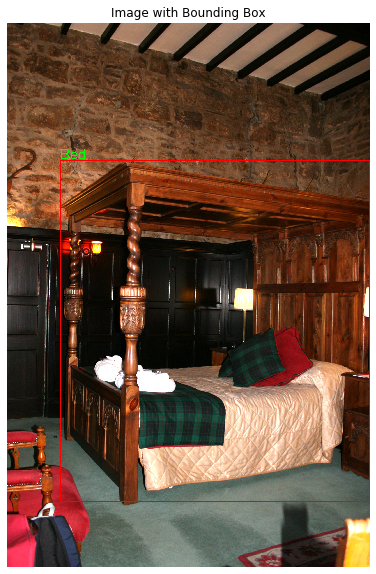

Image: (2592, 3888, 3)
Coordinates: (257, 1850), (923, 2331)
Coordinates: (0, 2010), (1547, 2589)
Coordinates: (612, 1313), (2750, 2589)


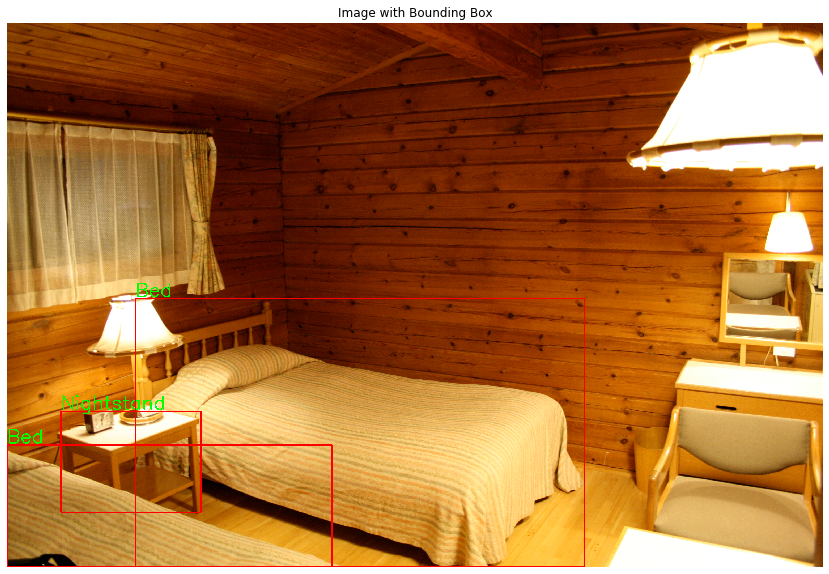

Image: (478, 640, 3)
Coordinates: (24, 261), (386, 438)
Coordinates: (0, 140), (639, 263)
Coordinates: (358, 146), (639, 258)
Coordinates: (30, 260), (387, 437)


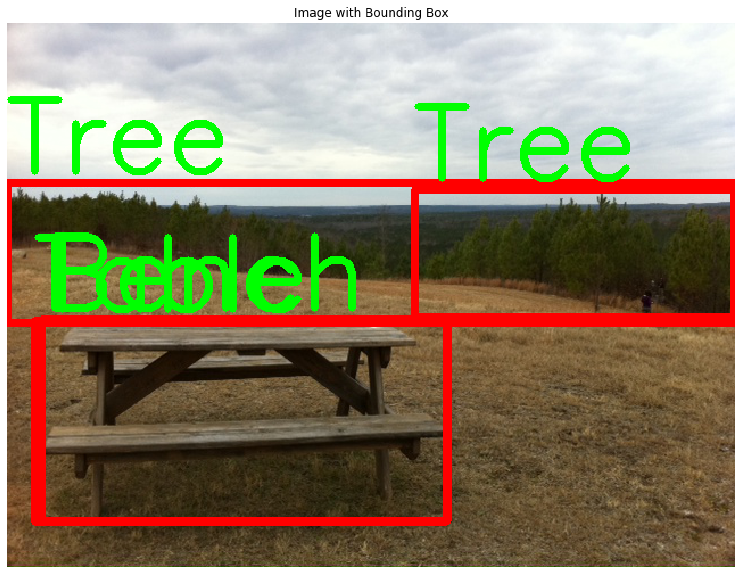

Image: (2048, 1536, 3)
Coordinates: (203, 253), (1534, 2046)
Coordinates: (509, 832), (642, 1082)
Coordinates: (680, 1009), (788, 1076)
Coordinates: (858, 846), (1062, 1086)
Coordinates: (0, 1091), (912, 2046)
Coordinates: (880, 1104), (1146, 1437)
Coordinates: (1429, 1181), (1534, 1559)
Coordinates: (0, 1086), (908, 2046)


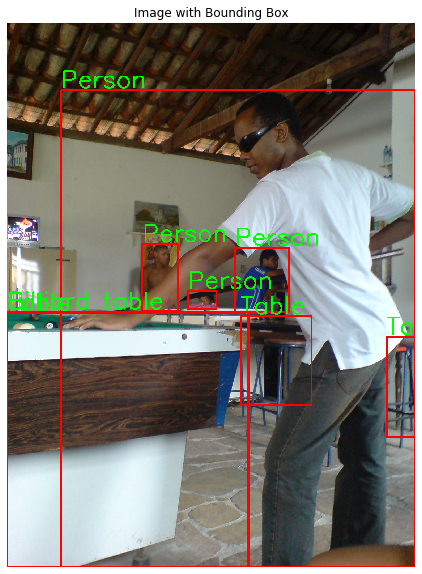

In [35]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique() # plotting the bounding box
for img_id in train_img_ids:
  plot_bbox(img_id)

In [36]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                val_df = val_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [37]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

In [38]:
#Write train.csv to annotation.txt

train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      train_file_path = 'C:/Users/Sijan Khan/Multiple_object_Dataset/train'
      fileName = os.path.join(train_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [39]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      test_file_path = 'C:/Users/Sijan Khan/Multiple_object_Dataset/train'
      fileName = os.path.join(test_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')